## Creating stylometry dataset

In [5]:
import requests
import pandas as pd
from tqdm import tqdm
import time
import random
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# Configure OpenAlex API
BASE_URL = "https://api.openalex.org/works"
EMAIL = "amantanwer97@gmail.com"  # Required for polite API usage
HEADERS = {"User-Agent": f"mailto:{EMAIL}"}

# Create a more resilient session with retry logic
def create_resilient_session():
    session = requests.Session()
    retry_strategy = Retry(
        total=10,  # Increased total number of retries
        backoff_factor=2,  # More aggressive exponential backoff
        status_forcelist=[429, 500, 502, 503, 504],  # Status codes to retry on
        allowed_methods=["GET"]  # Only retry GET requests
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    return session

# Updated select fields based on the error message
SELECT_FIELDS = [
    "id", "title", "doi", "publication_year", "authorships",
    "cited_by_count", "concepts", "abstract_inverted_index", "primary_location",
    "referenced_works_count", "related_works", "grants"
]

# Comprehensive stylometry search query - full query
STYLOMETRY_QUERY = {
    "search": (
        "stylometry OR 'authorship attribution' OR 'writing style analysis' OR "
    "'computational stylistics' OR 'literary fingerprint' OR 'text attribution'"
    ),
    "filter": "is_paratext:false,type:article",  # Research articles only
    "per_page": 200,  # Maximum allowed per page
    "select": ",".join(SELECT_FIELDS)
}

def fetch_stylometry_papers():
    """Fetch ALL stylometry papers from OpenAlex with pagination and retry logic"""
    results = []
    cursor = "*"
    session = create_resilient_session()
    
    with tqdm(desc="Fetching Stylometry Papers") as pbar:
        while cursor:
            params = {
                "cursor": cursor,
                "per_page": STYLOMETRY_QUERY['per_page'],
                "select": STYLOMETRY_QUERY['select'],
                "filter": STYLOMETRY_QUERY['filter'],
                "search": STYLOMETRY_QUERY['search']
            }
            
            try:
                response = session.get(
                    BASE_URL,
                    params=params,
                    headers=HEADERS,
                    timeout=60  # Increased timeout
                )
                
                if response.status_code == 200:
                    data = response.json()
                    batch_results = data.get("results", [])
                    results.extend(batch_results)
                    pbar.update(len(batch_results))
                    
                    # Update cursor for next page
                    cursor = data.get("meta", {}).get("next_cursor")
                    
                    # If no more results, break the loop
                    if not cursor or cursor == "null":
                        break
                    
                    # Add a moderate delay between requests
                    time.sleep(2)  # Consistent 2-second delay
                else:
                    print(f"Error: {response.status_code}")
                    print(f"Response: {response.text}")
                    
                    # Add longer backoff on error
                    print(f"Backing off for 30 seconds before retry...")
                    time.sleep(30)
                    
            except Exception as e:
                print(f"Connection error: {str(e)}")
                print("Retrying in 60 seconds...")
                time.sleep(60)
                
            # Save intermediate results every 1000 papers
            if len(results) % 1000 == 0 and len(results) > 0:
                print(f"\nSaving intermediate results: {len(results)} papers so far...")
                intermediate_df = process_papers(results)
                intermediate_df.to_csv(f"D:/DH_Results/openalex_stylometry_intermediate_{len(results)}.csv", index=False)
                
    return results

def safe_get(obj, *keys, default=""):
    """Safely navigate nested dictionaries without raising AttributeError"""
    if obj is None:
        return default
    
    current = obj
    for key in keys:
        if isinstance(current, dict) and key in current:
            current = current[key]
        else:
            return default
    
    return current if current is not None else default

def process_papers(papers):
    """Transform raw API data into structured DataFrame"""
    processed = []
    
    for paper in papers:
        # Convert abstract_inverted_index to string if it exists
        abstract = ""
        if "abstract_inverted_index" in paper and paper["abstract_inverted_index"]:
            try:
                # Try to reconstruct abstract from inverted index
                inverted_index = paper["abstract_inverted_index"]
                positions = []
                for word, pos_list in inverted_index.items():
                    for pos in pos_list:
                        positions.append((pos, word))
                positions.sort()
                abstract = " ".join([word for _, word in positions])
            except Exception as e:
                abstract = f"Abstract reconstruction failed: {str(e)[:100]}"
        
        record = {
            "title": paper.get("title", ""),
            "year": paper.get("publication_year"),
            "doi": paper.get("doi", ""),
            "citations": paper.get("cited_by_count", 0),
            "abstract": abstract[:2000],  # Truncate long abstracts
            "concepts": [c.get("display_name", "") for c in paper.get("concepts", []) if isinstance(c, dict)],
            "authors": [a.get("author", {}).get("display_name", "") for a in paper.get("authorships", []) if isinstance(a, dict)],
            "references": paper.get("referenced_works_count", 0),
            "open_access": safe_get(paper, "primary_location", "is_oa", default=False),
            "source": safe_get(paper, "primary_location", "source", "display_name"),
            "grants": [safe_get(g, "funder_display_name") for g in paper.get("grants", []) if isinstance(g, dict)]
        }
        processed.append(record)
    
    return pd.DataFrame(processed)

# Execute pipeline
print("Starting Stylometry Paper Collection...")
print("This will fetch ALL possible papers matching the stylometry search terms.")
print("The script will run until all papers are collected, which may take a long time.")
print("Intermediate results will be saved every 1000 papers.")

raw_papers = fetch_stylometry_papers()
print(f"\n Found {len(raw_papers)} papers in total")

if raw_papers:
    print("\n Processing Data...")
    df = process_papers(raw_papers)

    # Add relevance scoring
    df["stylometry_score"] = df.apply(
        lambda x: sum(1 for c in x["concepts"] if isinstance(c, str) and "stylometr" in c.lower()) + 
        sum(1 for t in ["stylometr", "attribution"] if isinstance(x["title"], str) and t in x["title"].lower()),
        axis=1
    )

    # Save final results
    df.to_csv("openalex_stylometry_dataset_complete.csv", index=False)
    print(f"\n Saved complete dataset with {len(df)} papers to openalex_stylometry_dataset_complete.csv")

    # Show summary
    print("\n Dataset Summary:")
    if not df.empty:
        print(f"Publication Years: {df['year'].min()} - {df['year'].max()}")
        print(f"Total Citations: {df['citations'].sum()}")
        print(f"Top 5 Journals:\n{df['source'].value_counts().head(5)}")
        
        # Extract concepts more safely
        all_concepts = []
        for concepts_list in df['concepts']:
            if isinstance(concepts_list, list):
                all_concepts.extend([c for c in concepts_list if isinstance(c, str)])
        
        print(f"Most Common Concepts:\n{pd.Series(all_concepts).value_counts().head(10)}")
        
        # Print papers with highest stylometry relevance
        print("\nMost Relevant Papers:")
        most_relevant = df.sort_values('stylometry_score', ascending=False).head(5)
        for _, paper in most_relevant.iterrows():
            print(f"- {paper['title']} ({paper['year']}) - Score: {paper['stylometry_score']}")
    else:
        print("DataFrame is empty. No data to summarize.")
else:
    print("No papers were retrieved. Check the API parameters and connection.")

🕵️ Starting Stylometry Paper Collection...
This will fetch ALL possible papers matching the stylometry search terms.
The script will run until all papers are collected, which may take a long time.
Intermediate results will be saved every 1000 papers.


Fetching Stylometry Papers: 1000it [00:11, 79.87it/s]


Saving intermediate results: 1000 papers so far...


Fetching Stylometry Papers: 2000it [00:43, 24.65it/s]


Saving intermediate results: 2000 papers so far...


Fetching Stylometry Papers: 3000it [00:57, 56.04it/s]


Saving intermediate results: 3000 papers so far...


Fetching Stylometry Papers: 4000it [01:11, 70.62it/s]


Saving intermediate results: 4000 papers so far...


Fetching Stylometry Papers: 5000it [01:25, 72.80it/s]


Saving intermediate results: 5000 papers so far...


Fetching Stylometry Papers: 6000it [01:39, 73.87it/s]


Saving intermediate results: 6000 papers so far...


Fetching Stylometry Papers: 7000it [01:53, 73.13it/s]


Saving intermediate results: 7000 papers so far...


Fetching Stylometry Papers: 8000it [02:07, 74.31it/s]


Saving intermediate results: 8000 papers so far...


Fetching Stylometry Papers: 9000it [02:21, 73.35it/s]


Saving intermediate results: 9000 papers so far...


Fetching Stylometry Papers: 10000it [02:36, 73.33it/s]


Saving intermediate results: 10000 papers so far...


Fetching Stylometry Papers: 11000it [02:50, 70.77it/s]


Saving intermediate results: 11000 papers so far...


Fetching Stylometry Papers: 12000it [03:04, 73.38it/s]


Saving intermediate results: 12000 papers so far...


Fetching Stylometry Papers: 13000it [03:19, 72.58it/s]


Saving intermediate results: 13000 papers so far...


Fetching Stylometry Papers: 14000it [03:33, 73.12it/s]


Saving intermediate results: 14000 papers so far...


Fetching Stylometry Papers: 15000it [03:48, 72.36it/s]


Saving intermediate results: 15000 papers so far...


Fetching Stylometry Papers: 16000it [04:03, 72.59it/s]


Saving intermediate results: 16000 papers so far...


Fetching Stylometry Papers: 17000it [04:18, 72.41it/s]


Saving intermediate results: 17000 papers so far...


Fetching Stylometry Papers: 18000it [04:33, 70.86it/s]


Saving intermediate results: 18000 papers so far...


Fetching Stylometry Papers: 19000it [04:48, 71.44it/s]


Saving intermediate results: 19000 papers so far...


Fetching Stylometry Papers: 20000it [05:03, 70.85it/s]


Saving intermediate results: 20000 papers so far...


Fetching Stylometry Papers: 21000it [05:19, 66.56it/s]


Saving intermediate results: 21000 papers so far...


Fetching Stylometry Papers: 22000it [05:35, 70.47it/s]


Saving intermediate results: 22000 papers so far...


Fetching Stylometry Papers: 23000it [05:50, 71.12it/s]


Saving intermediate results: 23000 papers so far...


Fetching Stylometry Papers: 24000it [06:05, 70.78it/s]


Saving intermediate results: 24000 papers so far...


Fetching Stylometry Papers: 25000it [06:21, 67.71it/s]


Saving intermediate results: 25000 papers so far...


Fetching Stylometry Papers: 26000it [06:37, 70.98it/s]


Saving intermediate results: 26000 papers so far...


Fetching Stylometry Papers: 27000it [06:56, 54.03it/s]


Saving intermediate results: 27000 papers so far...


Fetching Stylometry Papers: 28000it [07:22, 43.05it/s]


Saving intermediate results: 28000 papers so far...


Fetching Stylometry Papers: 29000it [07:43, 49.40it/s]


Saving intermediate results: 29000 papers so far...


Fetching Stylometry Papers: 30000it [08:04, 51.21it/s]


Saving intermediate results: 30000 papers so far...


Fetching Stylometry Papers: 31000it [08:24, 53.66it/s]


Saving intermediate results: 31000 papers so far...


Fetching Stylometry Papers: 32000it [08:48, 48.36it/s]


Saving intermediate results: 32000 papers so far...


Fetching Stylometry Papers: 33000it [09:09, 50.64it/s]


Saving intermediate results: 33000 papers so far...


Fetching Stylometry Papers: 34000it [09:32, 49.46it/s]


Saving intermediate results: 34000 papers so far...


Fetching Stylometry Papers: 35000it [09:54, 48.98it/s]


Saving intermediate results: 35000 papers so far...


Fetching Stylometry Papers: 36000it [10:15, 51.56it/s]


Saving intermediate results: 36000 papers so far...


Fetching Stylometry Papers: 37000it [10:39, 48.89it/s]


Saving intermediate results: 37000 papers so far...


Fetching Stylometry Papers: 38000it [11:03, 45.22it/s]


Saving intermediate results: 38000 papers so far...


Fetching Stylometry Papers: 39000it [11:26, 45.74it/s]


Saving intermediate results: 39000 papers so far...


Fetching Stylometry Papers: 40000it [11:48, 51.12it/s]


Saving intermediate results: 40000 papers so far...


Fetching Stylometry Papers: 41000it [12:11, 47.63it/s]


Saving intermediate results: 41000 papers so far...


Fetching Stylometry Papers: 42000it [12:33, 49.61it/s]


Saving intermediate results: 42000 papers so far...


Fetching Stylometry Papers: 43000it [12:57, 48.08it/s]


Saving intermediate results: 43000 papers so far...


Fetching Stylometry Papers: 44000it [13:22, 45.34it/s]


Saving intermediate results: 44000 papers so far...


Fetching Stylometry Papers: 45000it [13:45, 47.91it/s]


Saving intermediate results: 45000 papers so far...


Fetching Stylometry Papers: 46000it [14:08, 48.59it/s]


Saving intermediate results: 46000 papers so far...


Fetching Stylometry Papers: 47000it [14:31, 49.49it/s]


Saving intermediate results: 47000 papers so far...


Fetching Stylometry Papers: 48000it [14:55, 49.35it/s]


Saving intermediate results: 48000 papers so far...


Fetching Stylometry Papers: 49000it [15:19, 46.43it/s]


Saving intermediate results: 49000 papers so far...


Fetching Stylometry Papers: 50000it [15:42, 48.30it/s]


Saving intermediate results: 50000 papers so far...


Fetching Stylometry Papers: 51000it [16:06, 47.35it/s]


Saving intermediate results: 51000 papers so far...


Fetching Stylometry Papers: 52000it [16:29, 49.58it/s]


Saving intermediate results: 52000 papers so far...


Fetching Stylometry Papers: 53000it [16:53, 48.13it/s]


Saving intermediate results: 53000 papers so far...


Fetching Stylometry Papers: 54000it [17:20, 42.13it/s]


Saving intermediate results: 54000 papers so far...


Fetching Stylometry Papers: 55000it [17:45, 46.23it/s]


Saving intermediate results: 55000 papers so far...


Fetching Stylometry Papers: 56000it [18:08, 47.94it/s]


Saving intermediate results: 56000 papers so far...


Fetching Stylometry Papers: 57000it [18:32, 48.36it/s]


Saving intermediate results: 57000 papers so far...


Fetching Stylometry Papers: 58000it [18:58, 42.61it/s]


Saving intermediate results: 58000 papers so far...


Fetching Stylometry Papers: 59000it [19:22, 48.10it/s]


Saving intermediate results: 59000 papers so far...


Fetching Stylometry Papers: 60000it [19:47, 45.00it/s]


Saving intermediate results: 60000 papers so far...


Fetching Stylometry Papers: 61000it [20:10, 48.26it/s]


Saving intermediate results: 61000 papers so far...


Fetching Stylometry Papers: 62000it [20:34, 47.74it/s]


Saving intermediate results: 62000 papers so far...


Fetching Stylometry Papers: 63000it [20:59, 47.86it/s]


Saving intermediate results: 63000 papers so far...


Fetching Stylometry Papers: 64000it [21:25, 45.29it/s]


Saving intermediate results: 64000 papers so far...


Fetching Stylometry Papers: 65000it [22:33, 15.31it/s]


Saving intermediate results: 65000 papers so far...


Fetching Stylometry Papers: 66000it [22:58, 35.09it/s]


Saving intermediate results: 66000 papers so far...


Fetching Stylometry Papers: 67000it [23:21, 46.06it/s]


Saving intermediate results: 67000 papers so far...


Fetching Stylometry Papers: 68000it [23:45, 48.37it/s]


Saving intermediate results: 68000 papers so far...


Fetching Stylometry Papers: 69000it [24:11, 46.61it/s]


Saving intermediate results: 69000 papers so far...


Fetching Stylometry Papers: 70000it [24:37, 45.85it/s]


Saving intermediate results: 70000 papers so far...


Fetching Stylometry Papers: 71000it [25:02, 46.44it/s]


Saving intermediate results: 71000 papers so far...


Fetching Stylometry Papers: 72000it [25:26, 47.81it/s]


Saving intermediate results: 72000 papers so far...


Fetching Stylometry Papers: 73000it [25:51, 48.48it/s]


Saving intermediate results: 73000 papers so far...


Fetching Stylometry Papers: 74000it [26:16, 45.49it/s]


Saving intermediate results: 74000 papers so far...


Fetching Stylometry Papers: 75000it [26:48, 41.47it/s]


Saving intermediate results: 75000 papers so far...


Fetching Stylometry Papers: 76000it [27:13, 44.94it/s]


Saving intermediate results: 76000 papers so far...


Fetching Stylometry Papers: 77000it [27:40, 44.26it/s]


Saving intermediate results: 77000 papers so far...


Fetching Stylometry Papers: 78000it [28:04, 47.96it/s]


Saving intermediate results: 78000 papers so far...


Fetching Stylometry Papers: 79000it [28:31, 45.26it/s]


Saving intermediate results: 79000 papers so far...


Fetching Stylometry Papers: 80000it [28:58, 45.94it/s]


Saving intermediate results: 80000 papers so far...


Fetching Stylometry Papers: 81000it [29:30, 40.76it/s]


Saving intermediate results: 81000 papers so far...


Fetching Stylometry Papers: 82000it [29:58, 44.45it/s]


Saving intermediate results: 82000 papers so far...


Fetching Stylometry Papers: 83000it [30:24, 46.81it/s]


Saving intermediate results: 83000 papers so far...


Fetching Stylometry Papers: 84000it [30:50, 45.94it/s]


Saving intermediate results: 84000 papers so far...


Fetching Stylometry Papers: 85000it [31:16, 45.99it/s]


Saving intermediate results: 85000 papers so far...


Fetching Stylometry Papers: 86000it [31:42, 46.95it/s]


Saving intermediate results: 86000 papers so far...


Fetching Stylometry Papers: 87000it [32:12, 42.00it/s]


Saving intermediate results: 87000 papers so far...


Fetching Stylometry Papers: 88000it [32:40, 41.83it/s]


Saving intermediate results: 88000 papers so far...


Fetching Stylometry Papers: 89000it [33:08, 43.93it/s]


Saving intermediate results: 89000 papers so far...


Fetching Stylometry Papers: 90000it [33:35, 44.72it/s]


Saving intermediate results: 90000 papers so far...


Fetching Stylometry Papers: 91000it [34:05, 43.22it/s]


Saving intermediate results: 91000 papers so far...


Fetching Stylometry Papers: 92000it [34:32, 44.66it/s]


Saving intermediate results: 92000 papers so far...


Fetching Stylometry Papers: 93000it [35:03, 41.38it/s]


Saving intermediate results: 93000 papers so far...


Fetching Stylometry Papers: 94000it [35:31, 42.94it/s]


Saving intermediate results: 94000 papers so far...


Fetching Stylometry Papers: 95000it [35:58, 44.70it/s]


Saving intermediate results: 95000 papers so far...


Fetching Stylometry Papers: 96000it [36:26, 44.27it/s]


Saving intermediate results: 96000 papers so far...


Fetching Stylometry Papers: 97000it [36:53, 47.21it/s]


Saving intermediate results: 97000 papers so far...


Fetching Stylometry Papers: 98000it [37:20, 45.79it/s]


Saving intermediate results: 98000 papers so far...


Fetching Stylometry Papers: 99000it [37:50, 41.97it/s]


Saving intermediate results: 99000 papers so far...


Fetching Stylometry Papers: 100000it [38:18, 45.33it/s]


Saving intermediate results: 100000 papers so far...


Fetching Stylometry Papers: 101000it [38:48, 42.34it/s]


Saving intermediate results: 101000 papers so far...


Fetching Stylometry Papers: 102000it [39:15, 45.33it/s]


Saving intermediate results: 102000 papers so far...


Fetching Stylometry Papers: 103000it [39:43, 43.52it/s]


Saving intermediate results: 103000 papers so far...


Fetching Stylometry Papers: 104000it [40:12, 44.58it/s]


Saving intermediate results: 104000 papers so far...


Fetching Stylometry Papers: 105000it [40:46, 37.47it/s]


Saving intermediate results: 105000 papers so far...


Fetching Stylometry Papers: 106000it [41:20, 37.50it/s]


Saving intermediate results: 106000 papers so far...


Fetching Stylometry Papers: 107000it [41:53, 39.79it/s]


Saving intermediate results: 107000 papers so far...


Fetching Stylometry Papers: 108000it [42:22, 41.82it/s]


Saving intermediate results: 108000 papers so far...


Fetching Stylometry Papers: 109000it [42:50, 43.83it/s]


Saving intermediate results: 109000 papers so far...


Fetching Stylometry Papers: 110000it [43:18, 45.29it/s]


Saving intermediate results: 110000 papers so far...


Fetching Stylometry Papers: 111000it [43:46, 45.31it/s]


Saving intermediate results: 111000 papers so far...


Fetching Stylometry Papers: 112000it [44:19, 40.17it/s]


Saving intermediate results: 112000 papers so far...


Fetching Stylometry Papers: 113000it [44:47, 44.46it/s]


Saving intermediate results: 113000 papers so far...


Fetching Stylometry Papers: 114000it [45:15, 45.52it/s]


Saving intermediate results: 114000 papers so far...


Fetching Stylometry Papers: 115000it [45:42, 47.72it/s]


Saving intermediate results: 115000 papers so far...


Fetching Stylometry Papers: 116000it [46:18, 35.72it/s]


Saving intermediate results: 116000 papers so far...


Fetching Stylometry Papers: 117000it [46:49, 40.32it/s]


Saving intermediate results: 117000 papers so far...


Fetching Stylometry Papers: 118000it [47:18, 43.72it/s]


Saving intermediate results: 118000 papers so far...


Fetching Stylometry Papers: 119000it [47:49, 45.22it/s]


Saving intermediate results: 119000 papers so far...


Fetching Stylometry Papers: 120000it [48:18, 43.92it/s]


Saving intermediate results: 120000 papers so far...


Fetching Stylometry Papers: 121000it [48:47, 45.23it/s]


Saving intermediate results: 121000 papers so far...


Fetching Stylometry Papers: 122000it [49:17, 44.44it/s]


Saving intermediate results: 122000 papers so far...


Fetching Stylometry Papers: 123000it [49:45, 45.89it/s]


Saving intermediate results: 123000 papers so far...


Fetching Stylometry Papers: 124000it [50:17, 40.00it/s]


Saving intermediate results: 124000 papers so far...


Fetching Stylometry Papers: 125000it [50:44, 45.31it/s]


Saving intermediate results: 125000 papers so far...


Fetching Stylometry Papers: 126000it [51:15, 44.40it/s]


Saving intermediate results: 126000 papers so far...


Fetching Stylometry Papers: 127000it [51:43, 45.63it/s]


Saving intermediate results: 127000 papers so far...


Fetching Stylometry Papers: 128000it [52:12, 44.93it/s]


Saving intermediate results: 128000 papers so far...


Fetching Stylometry Papers: 129000it [52:46, 42.64it/s]


Saving intermediate results: 129000 papers so far...


Fetching Stylometry Papers: 130000it [53:16, 43.82it/s]


Saving intermediate results: 130000 papers so far...


Fetching Stylometry Papers: 131000it [53:44, 45.64it/s]


Saving intermediate results: 131000 papers so far...


Fetching Stylometry Papers: 132000it [54:13, 45.04it/s]


Saving intermediate results: 132000 papers so far...


Fetching Stylometry Papers: 133000it [54:48, 40.47it/s]


Saving intermediate results: 133000 papers so far...


Fetching Stylometry Papers: 134000it [55:17, 43.69it/s]


Saving intermediate results: 134000 papers so far...


Fetching Stylometry Papers: 135000it [55:48, 43.07it/s]


Saving intermediate results: 135000 papers so far...


Fetching Stylometry Papers: 136000it [56:19, 42.21it/s]


Saving intermediate results: 136000 papers so far...


Fetching Stylometry Papers: 137000it [56:50, 39.92it/s]


Saving intermediate results: 137000 papers so far...


Fetching Stylometry Papers: 138000it [57:22, 39.09it/s]


Saving intermediate results: 138000 papers so far...


Fetching Stylometry Papers: 139000it [57:54, 41.37it/s]


Saving intermediate results: 139000 papers so far...


Fetching Stylometry Papers: 140000it [58:26, 42.39it/s]


Saving intermediate results: 140000 papers so far...


Fetching Stylometry Papers: 141000it [58:57, 41.54it/s]


Saving intermediate results: 141000 papers so far...


Fetching Stylometry Papers: 142000it [59:28, 42.32it/s]


Saving intermediate results: 142000 papers so far...


Fetching Stylometry Papers: 143000it [1:00:01, 40.44it/s]


Saving intermediate results: 143000 papers so far...


Fetching Stylometry Papers: 144000it [1:00:31, 43.04it/s]


Saving intermediate results: 144000 papers so far...


Fetching Stylometry Papers: 145000it [1:01:02, 42.71it/s]


Saving intermediate results: 145000 papers so far...


Fetching Stylometry Papers: 146000it [1:01:38, 39.25it/s]


Saving intermediate results: 146000 papers so far...


Fetching Stylometry Papers: 147000it [1:02:09, 41.96it/s]


Saving intermediate results: 147000 papers so far...


Fetching Stylometry Papers: 148000it [1:02:41, 41.05it/s]


Saving intermediate results: 148000 papers so far...


Fetching Stylometry Papers: 148950it [1:03:13, 39.26it/s]



✅ Found 148950 papers in total

🧠 Processing Data...

💾 Saved complete dataset with 148950 papers to openalex_stylometry_dataset_complete.csv

📊 Dataset Summary:
Publication Years: 1838 - 2025
Total Citations: 5349628
Top 5 Journals:
source
                                   4673
The Art Bulletin                   2549
IEEE Access                        2061
American Journal of Archaeology     877
Frontiers in Psychology             863
Name: count, dtype: int64
Most Common Concepts:
Psychology           68079
Computer science     57109
Philosophy           46415
Political science    42685
Sociology            39601
Social psychology    37161
Law                  36745
Art                  35184
History              29726
Medicine             24692
Name: count, dtype: int64

Most Relevant Papers:
- Stylometry and Authorship Attribution: Introduction to the Special Issue (2012) - Score: 3
- The Effectiveness of Stemming in the Stylometric Authorship Attribution in Arabic (2020) - Score

In [6]:
paper.head(1000)

title               Visual stylometry using background selection a...
year                                                             2012
doi                      https://doi.org/10.1016/j.sigpro.2012.09.025
citations                                                          22
abstract                                                             
concepts            [Stylometry, Painting, Metric (unit), Represen...
authors                  [Hanchao Qi, Armeen Taeb, Shannon M. Hughes]
references                                                         33
open_access                                                     False
source                                              Signal Processing
grants                                                             []
stylometry_score                                                    3
Name: 6978, dtype: object

## Creating list of important papers based on citation count

Loading the stylometry dataset...
Dataset loaded: 148950 papers in total

 Dataset Overview:
Publication years: 1838 - 2025
Total citations: 5,349,628
Average citations per paper: 35.92
Median citations per paper: 5.00

 Top 20 Most Cited Papers:
1. Global cancer statistics 2018: GLOBOCAN estimates of incidence and mortality worldwide for 36 cancers in 185 countries (2018) - Citations: 76,017
   DOI: https://doi.org/10.3322/caac.21492
   Authors: N/A

2. Self-determination theory and the facilitation of intrinsic motivation, social development, and well-being. (2000) - Citations: 28,813
   DOI: https://doi.org/10.1037/0003-066x.55.1.68
   Authors: N/A

3. Self-determination theory and the facilitation of intrinsic motivation, social development, and well-being. (2000) - Citations: 23,667
   DOI: https://doi.org/10.1037//0003-066x.55.1.68
   Authors: N/A

4. Unpaired Image-to-Image Translation Using Cycle-Consistent Adversarial Networks (2017) - Citations: 19,021
   DOI: https://doi.org

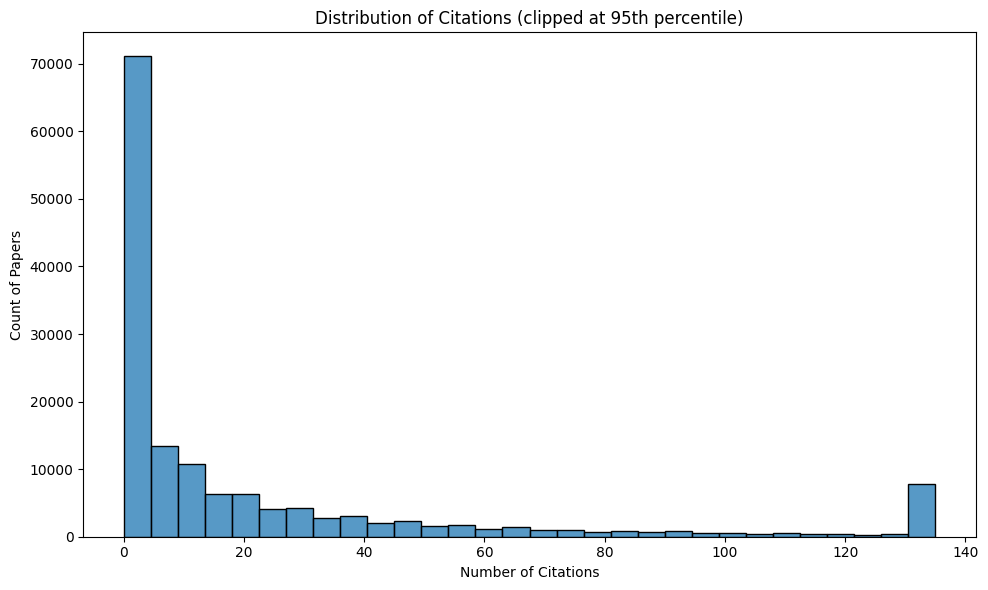

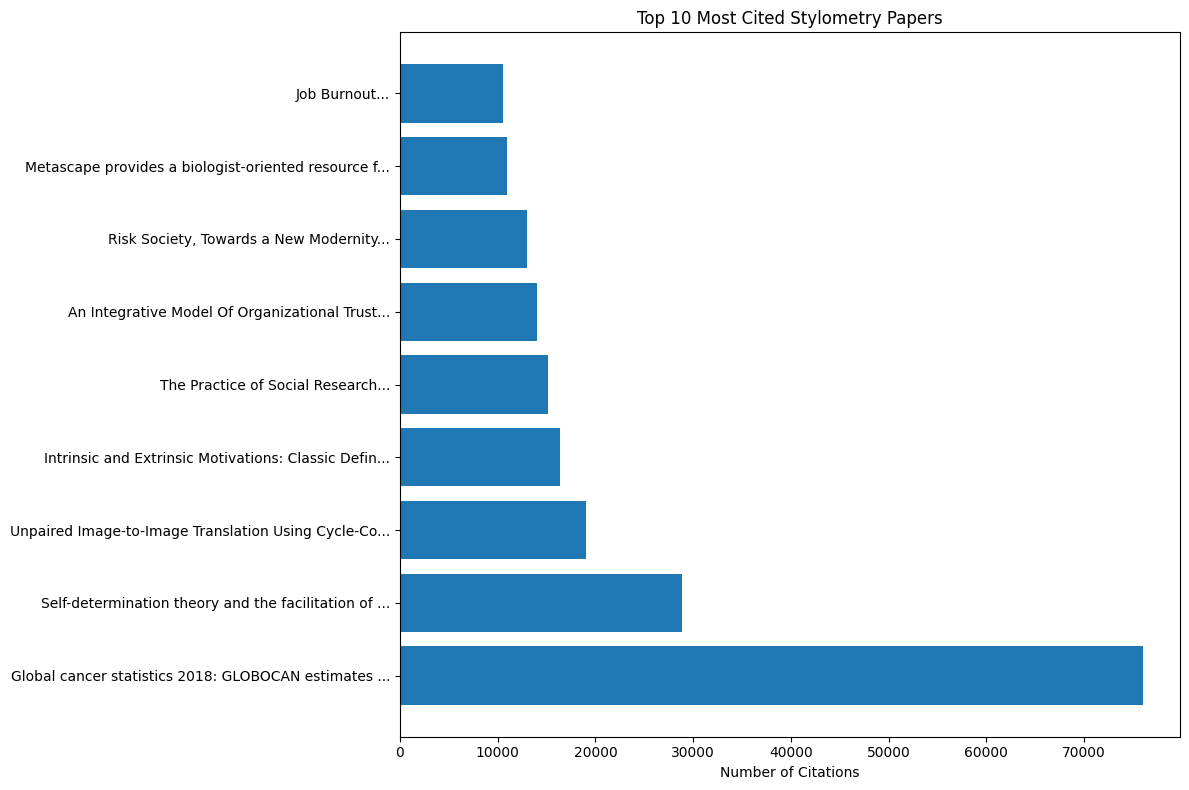

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
print("Loading the stylometry dataset...")
df = pd.read_csv("openalex_stylometry_dataset_complete.csv")

print(f"Dataset loaded: {len(df)} papers in total")

# Basic dataset statistics
print("\n Dataset Overview:")
print(f"Publication years: {df['year'].min()} - {df['year'].max()}")
print(f"Total citations: {df['citations'].sum():,}")
print(f"Average citations per paper: {df['citations'].mean():.2f}")
print(f"Median citations per paper: {df['citations'].median():.2f}")

# Sort papers by citation count (descending)
most_cited = df.sort_values('citations', ascending=False)

# Display the top 20 most cited papers
print("\n Top 20 Most Cited Papers:")
for i, (_, paper) in enumerate(most_cited.head(20).iterrows(), 1):
    print(f"{i}. {paper['title']} ({paper['year']}) - Citations: {paper['citations']:,}")
    print(f"   DOI: {paper['doi']}")
    print(f"   Authors: {', '.join(paper['authors'][:3]) if isinstance(paper['authors'], list) else 'N/A'}")
    if i < 20:
        print()  # Add line break between papers

# Create a visualization of citation distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['citations'].clip(upper=df['citations'].quantile(0.95)), bins=30)
plt.title('Distribution of Citations (clipped at 95th percentile)')
plt.xlabel('Number of Citations')
plt.ylabel('Count of Papers')
plt.tight_layout()
plt.savefig('citation_distribution.png')
print("\nCreated visualization of citation distribution (saved as 'citation_distribution.png')")

# Create a visualization of top papers by citation
top_papers = most_cited.head(10)
plt.figure(figsize=(12, 8))
bars = plt.barh(top_papers['title'].str.slice(0, 50) + '...', top_papers['citations'])
plt.xlabel('Number of Citations')
plt.title('Top 10 Most Cited Stylometry Papers')
plt.tight_layout()
plt.savefig('top_cited_papers.png')
print("Created visualization of top cited papers (saved as 'top_cited_papers.png')")

# Save the top 100 papers to a new CSV file
most_cited.head(100).to_csv('top_100_cited_stylometry_papers.csv', index=False)
print("\n Saved top 100 most cited papers to 'top_100_cited_stylometry_papers.csv'")

# Optional: Calculate citation-based metrics
df['citation_percentile'] = df['citations'].rank(pct=True) * 100
high_impact_papers = df[df['citation_percentile'] > 95]  # Top 5% by citation
print(f"\nHigh-impact papers (top 5% by citation): {len(high_impact_papers)}")
print(f"Citation threshold for high-impact papers: {high_impact_papers['citations'].min():,}+ citations")

# Add this to the previous script

# Create a combined importance score
# Normalize citations and stylometry_score to 0-1 range
df['norm_citations'] = df['citations'] / df['citations'].max()
df['norm_stylometry'] = df['stylometry_score'] / df['stylometry_score'].max()

# Combined score (70% citations, 30% stylometry relevance)
df['importance_score'] = (0.7 * df['norm_citations']) + (0.3 * df['norm_stylometry'])

# Sort by combined importance score
most_important = df.sort_values('importance_score', ascending=False)

# Display top 20 papers by importance score
print("\n Top 20 Most Important Papers (Citation + Relevance):")
for i, (_, paper) in enumerate(most_important.head(20).iterrows(), 1):
    print(f"{i}. {paper['title']} ({paper['year']})")
    print(f"   Citations: {paper['citations']:,} | Stylometry Score: {paper['stylometry_score']:.2f} | Importance: {paper['importance_score']:.3f}")
    print(f"   DOI: {paper['doi']}")
    if i < 20:
        print()

# Save top 100 important papers
most_important.head(10000).to_csv('top_10000_stylometry_papers_based_on_citation_count.csv', index=False)
print("\n Saved top 100 most important papers to 'top_100_important_stylometry_papers.csv'")

## Creating list of important papers based on PageRank

Loading the stylometry dataset...
Dataset loaded: 148950 papers in total

Creating citation network...


Adding nodes: 100%|█████████████████████████████████████████████████████████| 148950/148950 [00:08<00:00, 17906.36it/s]



Calculating PageRank...

 Top 20 Most Important Papers (PageRank + Stylometry Relevance):
1. Stylometry and Authorship Attribution: Introduction to the Special Issue (2012)
   PageRank: 0.000007 | Stylometry Score: 3.00
   Importance: 1.000
   DOI: https://doi.org/10.1080/0013838x.2012.668788

2. The Effectiveness of Stemming in the Stylometric Authorship Attribution in Arabic (2020)
   PageRank: 0.000007 | Stylometry Score: 3.00
   Importance: 1.000
   DOI: https://doi.org/10.14569/ijacsa.2020.0110114

3. Stylometric Authorship Attribution for the Middle Dutch Mystical Tradition from Groenendaal (2016)
   PageRank: 0.000007 | Stylometry Score: 3.00
   Importance: 1.000
   DOI: https://doi.org/10.1080/03096564.2016.1252077

4. Stylometry and Automatic Attribution of Medieval Liturgical Monodies (2018)
   PageRank: 0.000007 | Stylometry Score: 3.00
   Importance: 1.000
   DOI: https://doi.org/10.4000/ijcol.518

5. Visual stylometry using background selection and wavelet-HMT-based Fishe

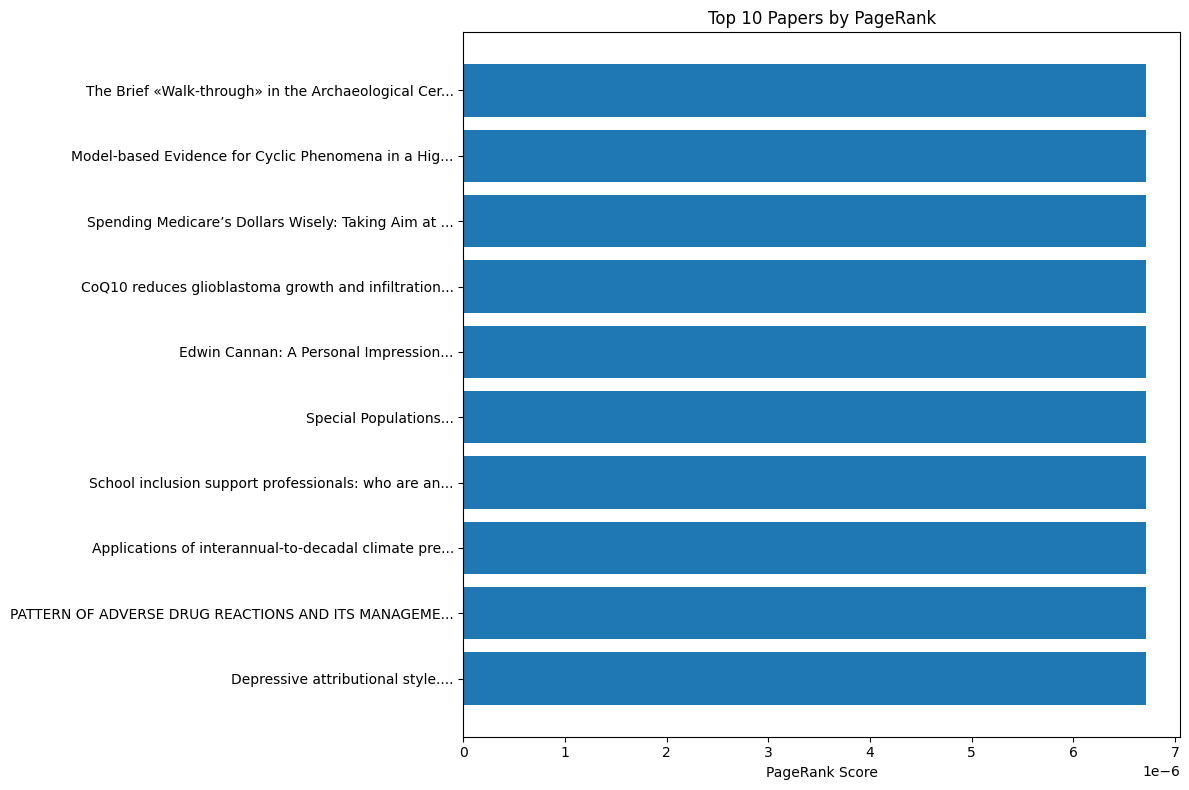

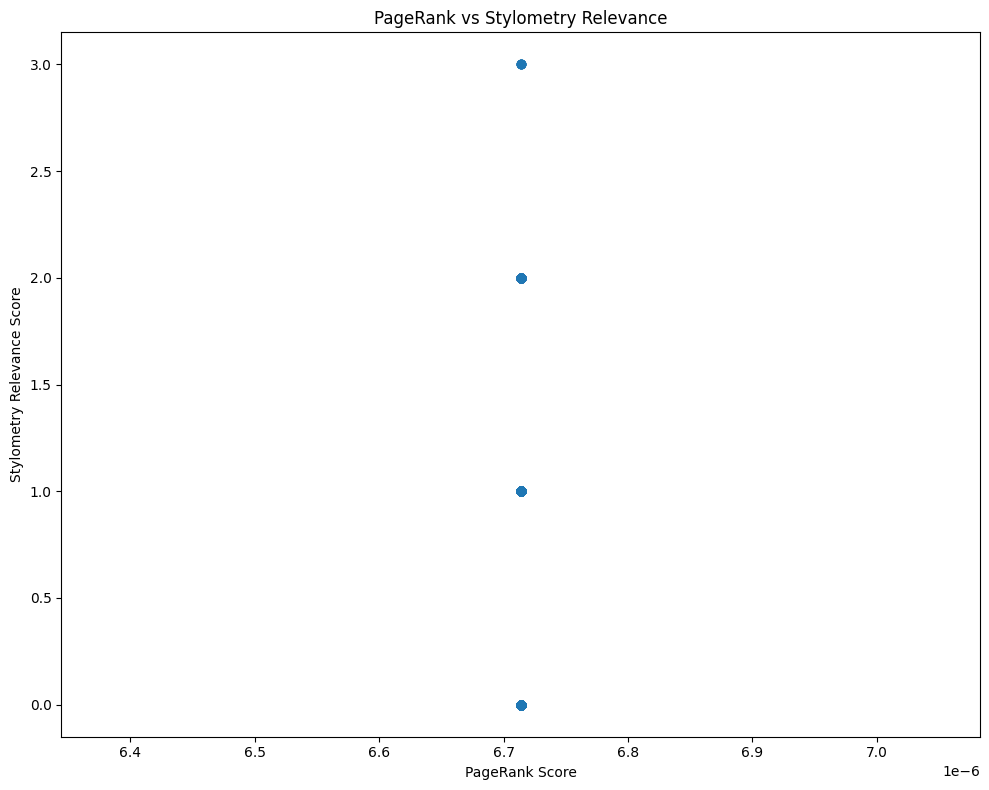

In [9]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Load the dataset
print("Loading the stylometry dataset...")
df = pd.read_csv("openalex_stylometry_dataset_complete.csv")

print(f"Dataset loaded: {len(df)} papers in total")

# Check if 'related_works' column exists and is usable
if 'related_works' not in df.columns or df['related_works'].isna().all():
    print("Warning: 'related_works' column is missing or empty. We'll use citation counts instead.")
    has_related_works = False
else:
    has_related_works = True

# Create a citation network using NetworkX
print("\nCreating citation network...")
G = nx.DiGraph()

# Add all papers as nodes first
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Adding nodes"):
    paper_id = row.get('id', f"paper_{idx}")
    G.add_node(paper_id, title=row['title'], year=row['year'], citations=row['citations'])

# Add edges based on related works (if available)
if has_related_works:
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Adding edges"):
        paper_id = row.get('id', f"paper_{idx}")
        
        # Check if related_works is a list or string representation of a list
        related = row.get('related_works', [])
        if isinstance(related, str):
            try:
                # Try to parse string as list
                related = eval(related)
            except:
                related = []
        
        # Add edges for each related work
        for ref_id in related:
            if ref_id in G:
                G.add_edge(ref_id, paper_id)  # Direction is from cited to citing

# Calculate PageRank
print("\nCalculating PageRank...")
pagerank = nx.pagerank(G, alpha=0.85)

# Add PageRank scores to the DataFrame
df['pagerank'] = 0.0
for idx, row in df.iterrows():
    paper_id = row.get('id', f"paper_{idx}")
    if paper_id in pagerank:
        df.at[idx, 'pagerank'] = pagerank[paper_id]

# Create a combined importance score
# Normalize PageRank and stylometry_score to 0-1 range
df['norm_pagerank'] = df['pagerank'] / df['pagerank'].max()
df['norm_stylometry'] = df['stylometry_score'] / df['stylometry_score'].max()

# Combined score (60% PageRank, 40% stylometry relevance)
df['importance_score'] = (0.6 * df['norm_pagerank']) + (0.4 * df['norm_stylometry'])

# Sort by combined importance score
most_important = df.sort_values('importance_score', ascending=False)

# Display top 20 papers by importance score
print("\n Top 20 Most Important Papers (PageRank + Stylometry Relevance):")
for i, (_, paper) in enumerate(most_important.head(20).iterrows(), 1):
    print(f"{i}. {paper['title']} ({paper['year']})")
    print(f"   PageRank: {paper['pagerank']:.6f} | Stylometry Score: {paper['stylometry_score']:.2f}")
    print(f"   Importance: {paper['importance_score']:.3f}")
    print(f"   DOI: {paper['doi']}")
    if i < 20:
        print()

# Create a visualization of top papers by PageRank
top_papers = df.sort_values('pagerank', ascending=False).head(10)
plt.figure(figsize=(12, 8))
bars = plt.barh(top_papers['title'].str.slice(0, 50) + '...', top_papers['pagerank'])
plt.xlabel('PageRank Score')
plt.title('Top 10 Papers by PageRank')
plt.tight_layout()
plt.savefig('top_pagerank_papers.png')
print("\nCreated visualization of top papers by PageRank (saved as 'top_pagerank_papers.png')")

# Create a scatter plot of PageRank vs Stylometry Score
plt.figure(figsize=(10, 8))
plt.scatter(df['pagerank'], df['stylometry_score'], alpha=0.5)
plt.xlabel('PageRank Score')
plt.ylabel('Stylometry Relevance Score')
plt.title('PageRank vs Stylometry Relevance')
plt.tight_layout()
plt.savefig('pagerank_vs_stylometry.png')
print("Created visualization of PageRank vs Stylometry (saved as 'pagerank_vs_stylometry.png')")

# Save the top 100 papers to a new CSV file
most_important.head(10000).to_csv('top_10000_stylometry_papers_based_on_PageRank.csv', index=False)
print("\n Saved top 100 most important papers to 'top_100_pagerank_stylometry_papers.csv'")

# Optional: Find papers with high stylometry relevance but low PageRank (hidden gems)
df['stylometry_percentile'] = df['stylometry_score'].rank(pct=True) * 100
df['pagerank_percentile'] = df['pagerank'].rank(pct=True) * 100

hidden_gems = df[(df['stylometry_percentile'] > 80) & (df['pagerank_percentile'] < 50)]
hidden_gems = hidden_gems.sort_values('stylometry_score', ascending=False)

print(f"\n Found {len(hidden_gems)} potential 'hidden gems' (high stylometry relevance but lower PageRank)")
print("Top 5 Hidden Gems:")
for i, (_, paper) in enumerate(hidden_gems.head(5).iterrows(), 1):
    print(f"{i}. {paper['title']} ({paper['year']})")
    print(f"   PageRank: {paper['pagerank']:.6f} | Stylometry Score: {paper['stylometry_score']:.2f}")
    print(f"   DOI: {paper['doi']}")
    if i < 5:
        print()

## Comparing both the lists with recommended papers

In [11]:
import pandas as pd
import re
import os
from fuzzywuzzy import fuzz, process
from collections import defaultdict

def extract_author_surnames(author_string):
    """Extract author surnames from various author string formats."""
    if pd.isna(author_string):
        return []
    
    # Handle list-like strings that may be present in pandas output
    if author_string.startswith('[') and author_string.endswith(']'):
        try:
            # Try to parse as a literal Python list
            authors = eval(author_string)
            if isinstance(authors, list):
                return [a.split()[-1] if ' ' in a else a for a in authors]
        except:
            pass
    
    # Try different separators
    for sep in [', ', ' and ', ';', ' & ']:
        if sep in author_string:
            authors = [name.strip() for name in author_string.split(sep)]
            return [a.split()[-1] if ' ' in a else a for a in authors]
    
    # If no separators found, assume it's a single author
    return [author_string.split()[-1] if ' ' in author_string else author_string]

def parse_recommended_readings(file_path):
    """Parse the recommended readings text file into a structured format."""
    papers = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    # Split by consecutive newlines to separate entries
    entries = re.split(r'\n\s*\n', content)
    
    for entry in entries:
        if not entry.strip():
            continue
        
        paper = {}
        lines = entry.strip().split('\n')
        
        # Try to extract the full reference from the first line
        if lines:
            # Extract authors
            first_line = lines[0].strip()
            author_match = re.match(r'^([^\.]+)\.', first_line)
            if author_match:
                paper['authors_raw'] = author_match.group(1).strip()
                surnames = []
                for auth in re.split(r',\s|\sand\s', paper['authors_raw']):
                    surname = auth.strip().split()[-1]
                    surnames.append(surname)
                paper['author_surnames'] = surnames
            
            # Extract title
            title_match = re.search(r'"([^"]+)"', ' '.join(lines))
            if title_match:
                paper['title'] = title_match.group(1).strip()
            else:
                # Alternative: Look for title after period
                period_split = first_line.split('.', 1)
                if len(period_split) > 1:
                    paper['title'] = period_split[1].strip()
            
            # Extract year
            year_match = re.search(r'\((\d{4})\)', ' '.join(lines))
            if year_match:
                paper['year'] = int(year_match.group(1))
            
            # Store the full text for reference
            paper['full_text'] = entry.strip()
            
            papers.append(paper)
    
    # Remove papers without titles
    papers = [p for p in papers if 'title' in p and p['title']]
    
    # Clean titles by removing extra whitespace and quotes
    for paper in papers:
        if 'title' in paper:
            paper['title'] = paper['title'].strip(' "')
    
    return papers

def match_papers(df_papers, recommended_papers, method_name):
    """
    Match papers from a DataFrame with the recommended papers using multiple criteria.
    Returns a list of matches and the DataFrame with match information.
    """
    # Add columns to track matches
    df_papers = df_papers.copy()
    df_papers['recommended_match'] = False
    df_papers['match_score'] = 0
    df_papers['matched_title'] = ''
    
    matches = []
    
    # Normalize titles in the DataFrame
    df_papers['normalized_title'] = df_papers['title'].str.lower().str.strip()
    
    # First pass: Try exact title matches or very close matches
    for i, rec_paper in enumerate(recommended_papers):
        if 'title' not in rec_paper:
            continue
            
        rec_title = rec_paper['title'].lower().strip()
        
        # Try direct match first
        direct_matches = df_papers[df_papers['normalized_title'] == rec_title]
        
        if not direct_matches.empty:
            for _, match in direct_matches.iterrows():
                matches.append({
                    'recommended': rec_paper,
                    'matched': match,
                    'score': 100,
                    'match_type': 'exact_title'
                })
                df_papers.loc[df_papers['title'] == match['title'], 'recommended_match'] = True
                df_papers.loc[df_papers['title'] == match['title'], 'match_score'] = 100
                df_papers.loc[df_papers['title'] == match['title'], 'matched_title'] = rec_paper['title']
        else:
            # Try fuzzy matching on title
            best_match = None
            best_score = 0
            
            for _, row in df_papers.iterrows():
                if not pd.isna(row['title']):
                    score = fuzz.token_sort_ratio(rec_title, row['title'].lower())
                    
                    # Check if years match to improve confidence
                    year_bonus = 0
                    if 'year' in rec_paper and 'year' in row and not pd.isna(row['year']):
                        if rec_paper['year'] == int(row['year']):
                            year_bonus = 10
                    
                    final_score = score + year_bonus
                    
                    if final_score > best_score and final_score >= 80:  # Higher threshold for title-only match
                        best_score = final_score
                        best_match = row
            
            if best_match is not None:
                matches.append({
                    'recommended': rec_paper,
                    'matched': best_match,
                    'score': best_score,
                    'match_type': 'fuzzy_title'
                })
                df_papers.loc[df_papers['title'] == best_match['title'], 'recommended_match'] = True
                df_papers.loc[df_papers['title'] == best_match['title'], 'match_score'] = best_score
                df_papers.loc[df_papers['title'] == best_match['title'], 'matched_title'] = rec_paper['title']
    
    # Second pass: Try author + year + keyword matching for remaining unmatched papers
    unmatched_recommended = [p for p in recommended_papers if 'title' in p and not any(m['recommended']['title'] == p['title'] for m in matches)]
    
    for rec_paper in unmatched_recommended:
        if 'author_surnames' not in rec_paper or 'year' not in rec_paper:
            continue
            
        rec_surnames = rec_paper['author_surnames']
        rec_year = rec_paper['year']
        rec_title_words = set(re.findall(r'\b\w+\b', rec_paper['title'].lower()))
        
        for _, row in df_papers[~df_papers['recommended_match']].iterrows():
            if pd.isna(row['title']) or pd.isna(row['year']):
                continue
                
            # Extract author surnames from DataFrame
            if 'authors' in row and not pd.isna(row['authors']):
                df_surnames = extract_author_surnames(row['authors'])
            else:
                df_surnames = []
            
            # Check if any author surnames match
            author_match = any(surname in df_surnames for surname in rec_surnames)
            
            # Check if year matches
            year_match = abs(rec_year - int(row['year'])) <= 1
            
            # Check if key words match
            row_title_words = set(re.findall(r'\b\w+\b', row['title'].lower()))
            common_words = rec_title_words.intersection(row_title_words)
            word_match_ratio = len(common_words) / len(rec_title_words) if rec_title_words else 0
            
            # Combined score
            score = 0
            if author_match:
                score += 30
            if year_match:
                score += 20
            score += int(word_match_ratio * 50)
            
            if score >= 70:  # Lower threshold for multi-criteria match
                matches.append({
                    'recommended': rec_paper,
                    'matched': row,
                    'score': score,
                    'match_type': 'author_year_keyword'
                })
                df_papers.loc[df_papers['title'] == row['title'], 'recommended_match'] = True
                df_papers.loc[df_papers['title'] == row['title'], 'match_score'] = score
                df_papers.loc[df_papers['title'] == row['title'], 'matched_title'] = rec_paper['title']
    
    print(f"\n{method_name} method matched {len(matches)} papers with the recommended list.")
    
    return matches, df_papers

def inspect_data_structure(df, name):
    """Helper function to inspect the structure of a DataFrame."""
    print(f"\n--- {name} Structure ---")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Sample data
    if not df.empty:
        print("\nSample row:")
        print(df.iloc[0])

def compare_methods(citation_matches, pagerank_matches, citation_df, pagerank_df):
    """Compare the results of both methods and provide detailed analysis."""
    citation_count = len(citation_matches)
    pagerank_count = len(pagerank_matches)
    
    print(f"\n--- COMPARISON RESULTS ---")
    print(f"Citation method matched {citation_count} papers with the recommended list.")
    print(f"PageRank method matched {pagerank_count} papers with the recommended list.")
    
    if citation_count > pagerank_count:
        print("\nThe Citation method performs better in matching with recommended papers.")
    elif pagerank_count > citation_count:
        print("\nThe PageRank method performs better in matching with recommended papers.")
    else:
        print("\nBoth methods perform equally in matching with recommended papers.")
    
    # Find papers matched by both methods
    citation_matched_titles = [match['matched']['title'] for match in citation_matches]
    pagerank_matched_titles = [match['matched']['title'] for match in pagerank_matches]
    
    common_matches = set(citation_matched_titles).intersection(set(pagerank_matched_titles))
    citation_unique = set(citation_matched_titles) - common_matches
    pagerank_unique = set(pagerank_matched_titles) - common_matches
    
    print(f"\nPapers matched by both methods: {len(common_matches)}")
    print(f"Unique matches from Citation method: {len(citation_unique)}")
    print(f"Unique matches from PageRank method: {len(pagerank_unique)}")
    
    # Calculate overlap percentage
    if citation_count > 0 and pagerank_count > 0:
        overlap_pct = (len(common_matches) / min(citation_count, pagerank_count)) * 100
        print(f"\nOverlap percentage: {overlap_pct:.2f}%")
    
    # Generate detailed report
    with open("comparison_results_10000.txt", "w", encoding="utf-8") as f:
        f.write("=== STYLOMETRY PAPER COMPARISON RESULTS ===\n\n")
        f.write(f"Citation method matched: {citation_count} papers\n")
        f.write(f"PageRank method matched: {pagerank_count} papers\n")
        
        if citation_count > pagerank_count:
            f.write("\nThe Citation method performs better in matching with recommended papers.\n")
        elif pagerank_count > citation_count:
            f.write("\nThe PageRank method performs better in matching with recommended papers.\n")
        else:
            f.write("\nBoth methods perform equally in matching with recommended papers.\n")
        
        f.write(f"\nPapers matched by both methods: {len(common_matches)}\n")
        f.write(f"Papers matched only by Citation method: {len(citation_unique)}\n")
        f.write(f"Papers matched only by PageRank method: {len(pagerank_unique)}\n")
        
        # Write common matches
        f.write("\n\n=== PAPERS MATCHED BY BOTH METHODS ===\n")
        for title in common_matches:
            f.write(f"- {title}\n")
        
        # Write unique citation matches
        f.write("\n\n=== PAPERS MATCHED ONLY BY CITATION METHOD ===\n")
        for title in citation_unique:
            f.write(f"- {title}\n")
        
        # Write unique pagerank matches
        f.write("\n\n=== PAPERS MATCHED ONLY BY PAGERANK METHOD ===\n")
        for title in pagerank_unique:
            f.write(f"- {title}\n")
        
        # Write details of all matches for citation method
        f.write("\n\n=== DETAILED CITATION METHOD MATCHES ===\n")
        for match in sorted(citation_matches, key=lambda x: x['score'], reverse=True):
            f.write(f"\nRecommended Paper: {match['recommended']['title']}\n")
            if 'year' in match['recommended']:
                f.write(f"Year: {match['recommended']['year']}\n")
            if 'author_surnames' in match['recommended']:
                f.write(f"Authors: {', '.join(match['recommended']['author_surnames'])}\n")
            f.write(f"Matched with: {match['matched']['title']}\n")
            if 'year' in match['matched'] and not pd.isna(match['matched']['year']):
                f.write(f"Year: {match['matched']['year']}\n")
            if 'authors' in match['matched'] and not pd.isna(match['matched']['authors']):
                f.write(f"Authors: {match['matched']['authors']}\n")
            f.write(f"Match Score: {match['score']}\n")
            f.write(f"Match Type: {match['match_type']}\n")
        
        # Write details of all matches for pagerank method
        f.write("\n\n=== DETAILED PAGERANK METHOD MATCHES ===\n")
        for match in sorted(pagerank_matches, key=lambda x: x['score'], reverse=True):
            f.write(f"\nRecommended Paper: {match['recommended']['title']}\n")
            if 'year' in match['recommended']:
                f.write(f"Year: {match['recommended']['year']}\n")
            if 'author_surnames' in match['recommended']:
                f.write(f"Authors: {', '.join(match['recommended']['author_surnames'])}\n")
            f.write(f"Matched with: {match['matched']['title']}\n")
            if 'year' in match['matched'] and not pd.isna(match['matched']['year']):
                f.write(f"Year: {match['matched']['year']}\n")
            if 'authors' in match['matched'] and not pd.isna(match['matched']['authors']):
                f.write(f"Authors: {match['matched']['authors']}\n")
            f.write(f"Match Score: {match['score']}\n")
            f.write(f"Match Type: {match['match_type']}\n")
    
    print(f"\nDetailed comparison results have been saved to 'comparison_results.txt'")
    
    return {
        'citation_count': citation_count,
        'pagerank_count': pagerank_count,
        'common_count': len(common_matches),
        'citation_unique': len(citation_unique),
        'pagerank_unique': len(pagerank_unique)
    }

def main():
    """Main function to run the comparison."""
    print("Stylometry Papers Comparison Tool")
    print("--------------------------------")
    
    # File paths
    citation_file = "top_100_important_stylometry_papers.csv"
    pagerank_file = "top_100_pagerank_stylometry_papers.csv"
    recommended_file = "Recommended_readings.txt"
    
    # Check if files exist
    for file_path in [citation_file, pagerank_file, recommended_file]:
        if not os.path.exists(file_path):
            print(f"Error: File '{file_path}' not found.")
            return
    
    # Load data
    try:
        citation_df = pd.read_csv(citation_file)
        pagerank_df = pd.read_csv(pagerank_file)
        
        # Ensure column names are consistent
        required_columns = ['title', 'year']
        for df_name, df in [('Citation', citation_df), ('PageRank', pagerank_df)]:
            missing_cols = [col for col in required_columns if col not in df.columns]
            if missing_cols:
                print(f"Warning: {df_name} DataFrame is missing required columns: {missing_cols}")
                
                # Try to find alternative column names
                for missing in missing_cols:
                    if missing == 'title':
                        potential_cols = ['Title', 'paper_title', 'name']
                    elif missing == 'year':
                        potential_cols = ['Year', 'publication_year', 'pub_year', 'date']
                    
                    for potential in potential_cols:
                        if potential in df.columns:
                            df[missing] = df[potential]
                            print(f"Using '{potential}' as '{missing}'")
                            break
        
        # Parse recommended readings
        recommended_papers = parse_recommended_readings(recommended_file)
        
        print(f"Loaded {len(citation_df)} papers from citation method.")
        print(f"Loaded {len(pagerank_df)} papers from PageRank method.")
        print(f"Parsed {len(recommended_papers)} recommended papers.")
        
        # Inspect data structure
        inspect_data_structure(citation_df, "Citation DataFrame")
        inspect_data_structure(pagerank_df, "PageRank DataFrame")
        
        # Sample recommended papers
        if recommended_papers:
            print("\n--- Sample Recommended Paper ---")
            for key, value in recommended_papers[0].items():
                print(f"{key}: {value}")
        
        # Find matches
        citation_matches, citation_df_with_matches = match_papers(citation_df, recommended_papers, "Citation")
        pagerank_matches, pagerank_df_with_matches = match_papers(pagerank_df, recommended_papers, "PageRank")
        
        # Compare results
        comparison_results = compare_methods(citation_matches, pagerank_matches, citation_df_with_matches, pagerank_df_with_matches)
        
        # Save matched DataFrames
        citation_df_with_matches.to_csv("citation_matches.csv", index=False)
        pagerank_df_with_matches.to_csv("pagerank_matches.csv", index=False)
        
        print("\nAnalysis complete. Results files have been saved:")
        print("- comparison_results.txt: Detailed comparison of both methods")
        print("- citation_matches.csv: Citation method papers with match information")
        print("- pagerank_matches.csv: PageRank method papers with match information")
        
    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Stylometry Papers Comparison Tool
--------------------------------
Loaded 10000 papers from citation method.
Loaded 10000 papers from PageRank method.
Parsed 39 recommended papers.

--- Citation DataFrame Structure ---
Shape: (10000, 16)
Columns: ['title', 'year', 'doi', 'citations', 'abstract', 'concepts', 'authors', 'references', 'open_access', 'source', 'grants', 'stylometry_score', 'citation_percentile', 'norm_citations', 'norm_stylometry', 'importance_score']

Sample row:
title                  Global cancer statistics 2018: GLOBOCAN estima...
year                                                                2018
doi                                   https://doi.org/10.3322/caac.21492
citations                                                          76017
abstract               Abstract This article provides a status report...
concepts               ['Cancer', 'Colorectal cancer', 'Medicine', 'S...
authors                ['Freddie Bray', 'Jacques Ferlay', 'Isabelle S...
referen

## Rank Correlation

In [15]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, kendalltau

def apply_rank_correlation(citation_df, pagerank_df):
    """Apply rank correlation to compare citation and PageRank methods."""
    print("\n--- RANK CORRELATION ANALYSIS ---")
    
    # Ensure we have the same papers in both DataFrames
    citation_df['paper_id'] = citation_df['title'] + '_' + citation_df['year'].astype(str)
    pagerank_df['paper_id'] = pagerank_df['title'] + '_' + pagerank_df['year'].astype(str)
    
    # Find common papers
    common_papers = set(citation_df['paper_id']).intersection(set(pagerank_df['paper_id']))
    print(f"Number of common papers between both methods: {len(common_papers)}")
    
    # Filter for common papers - ensure we create new dataframes
    citation_common = citation_df[citation_df['paper_id'].isin(common_papers)].copy()
    pagerank_common = pagerank_df[pagerank_df['paper_id'].isin(common_papers)].copy()
    
    # Create a merged dataframe to ensure perfect alignment
    merged_df = citation_common[['paper_id', 'citations', 'importance_score']].merge(
        pagerank_common[['paper_id', 'pagerank', 'importance_score']],
        on='paper_id',
        suffixes=('_citation', '_pagerank')
    )
    
    print(f"Successfully aligned {len(merged_df)} papers for correlation analysis")
    
    # Now extract metrics from the properly aligned dataframe
    citation_metrics = {
        'citations': merged_df['citations'].values,
        'importance_score': merged_df['importance_score_citation'].values
    }
    
    pagerank_metrics = {
        'pagerank': merged_df['pagerank'].values,
        'importance_score': merged_df['importance_score_pagerank'].values
    }
    
    # Calculate Spearman correlation
    spearman_citations_vs_pagerank = spearmanr(citation_metrics['citations'], pagerank_metrics['pagerank'])
    spearman_importance_scores = spearmanr(citation_metrics['importance_score'], pagerank_metrics['importance_score'])
    
    # Calculate Kendall's Tau
    kendall_citations_vs_pagerank = kendalltau(citation_metrics['citations'], pagerank_metrics['pagerank'])
    kendall_importance_scores = kendalltau(citation_metrics['importance_score'], pagerank_metrics['importance_score'])
    
    # Print results
    print("\nSpearman's Rank Correlation:")
    print(f"Citations vs PageRank: {spearman_citations_vs_pagerank.correlation:.4f} (p-value: {spearman_citations_vs_pagerank.pvalue:.4f})")
    print(f"Importance Scores: {spearman_importance_scores.correlation:.4f} (p-value: {spearman_importance_scores.pvalue:.4f})")
    
    print("\nKendall's Tau:")
    print(f"Citations vs PageRank: {kendall_citations_vs_pagerank.correlation:.4f} (p-value: {kendall_citations_vs_pagerank.pvalue:.4f})")
    print(f"Importance Scores: {kendall_importance_scores.correlation:.4f} (p-value: {kendall_importance_scores.pvalue:.4f})")
    
    # Save the aligned data for verification if needed
    merged_df.to_csv("aligned_papers_for_correlation.csv", index=False)
    
    return merged_df  # Return the aligned dataframe for potential further analysis
def main():
    """Main function to run the comparison."""
    print("Stylometry Papers Comparison Tool")
    print("--------------------------------")
    
    # File paths
    citation_file = "top_100_stylometry_papers_based_on_citation_count.csv"
    pagerank_file = "top_100_stylometry_papers_based_on_PageRank.csv"
    recommended_file = "Recommended_readings.txt"
    
    # Check if files exist
    for file_path in [citation_file, pagerank_file, recommended_file]:
        if not os.path.exists(file_path):
            print(f"Error: File '{file_path}' not found.")
            return
    
    # Load data
    try:
        citation_df = pd.read_csv(citation_file)
        pagerank_df = pd.read_csv(pagerank_file)
        
        # Ensure column names are consistent
        required_columns = ['title', 'year']
        for df_name, df in [('Citation', citation_df), ('PageRank', pagerank_df)]:
            missing_cols = [col for col in required_columns if col not in df.columns]
            if missing_cols:
                print(f"Warning: {df_name} DataFrame is missing required columns: {missing_cols}")
                
                # Try to find alternative column names
                for missing in missing_cols:
                    if missing == 'title':
                        potential_cols = ['Title', 'paper_title', 'name']
                    elif missing == 'year':
                        potential_cols = ['Year', 'publication_year', 'pub_year', 'date']
                    
                    for potential in potential_cols:
                        if potential in df.columns:
                            df[missing] = df[potential]
                            print(f"Using '{potential}' as '{missing}'")
                            break
        
        # Parse recommended readings
        recommended_papers = parse_recommended_readings(recommended_file)
        
        print(f"Loaded {len(citation_df)} papers from citation method.")
        print(f"Loaded {len(pagerank_df)} papers from PageRank method.")
        print(f"Parsed {len(recommended_papers)} recommended papers.")
        
        # Find matches
        citation_matches, citation_df_with_matches = match_papers(citation_df, recommended_papers, "Citation")
        pagerank_matches, pagerank_df_with_matches = match_papers(pagerank_df, recommended_papers, "PageRank")
        
        # Compare results
        comparison_results = compare_methods(citation_matches, pagerank_matches, citation_df_with_matches, pagerank_df_with_matches)
        
        # Apply rank correlation analysis
        apply_rank_correlation(citation_df, pagerank_df)
        
        # Save matched DataFrames
        citation_df_with_matches.to_csv("citation_matches.csv", index=False)
        pagerank_df_with_matches.to_csv("pagerank_matches.csv", index=False)
        
        print("\nAnalysis complete.")
        
    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Stylometry Papers Comparison Tool
--------------------------------
Loaded 100 papers from citation method.
Loaded 100 papers from PageRank method.
Parsed 39 recommended papers.

Citation method matched 5 papers with the recommended list.

PageRank method matched 3 papers with the recommended list.

--- COMPARISON RESULTS ---
Citation method matched 5 papers with the recommended list.
PageRank method matched 3 papers with the recommended list.

The Citation method performs better in matching with recommended papers.

Papers matched by both methods: 3
Unique matches from Citation method: 2
Unique matches from PageRank method: 0

Overlap percentage: 100.00%

Detailed comparison results have been saved to 'comparison_results.txt'

--- RANK CORRELATION ANALYSIS ---
Number of common papers between both methods: 62
Successfully aligned 62 papers for correlation analysis

Spearman's Rank Correlation:
Citations vs PageRank: nan (p-value: nan)
Importance Scores: 0.7249 (p-value: 0.0000)

Kendall

C:\Users\AMAN\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
